#Course 04

##Week 03

###Install the Updated Libraries 

In [0]:
!pip install tensorflow==2.0.0-beta0

In [0]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta0


###RNN based model for the Sequence data 

Define the Functions for the series data formation :

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow

# a function to plot the data series :

def plot_series(time , series , start = 0, end = None, format = '-'):
  plt.plot(time[start:end],series[start:end],format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)


def trend(x , slope = 0):
  return slope * x

def seasonality(x , period , amplitude= 1 , phase = 0 ):
  season_time = ((x+phase)%period)/period
  return amplitude * seasonal_pattern(season_time)

def seasonal_pattern(season_time):
  return np.where(season_time < 0.4 , np.cos(season_time * np.pi * 2), 1 /(np.exp(3*season_time)))

def noise_function(time , noise_level = 1 , seed = None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time))* noise_level


Now lets use the defined functions to develop a complex series :


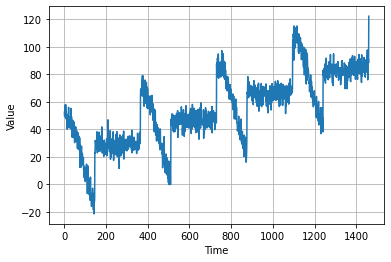

In [0]:
time = np.arange(4*365 + 1 , dtype = "float32")
slope = 0.05

baseline = 10 
amplitude = 40 
noise_level = 5

series = baseline +\
         trend(time , slope) +\
         seasonality(time , period = 365 , amplitude = amplitude) +\
         noise_function(time , noise_level, seed = 42)

plot_series(time , series)
plt.show()

Now lets devide the data into train and test set :

In [0]:
split_time = 1000

x_train = series[:split_time]
train_time = time[:split_time]

x_test =  series[split_time:]
test_time = time[split_time:]

print(x_train.shape , x_test.shape)

(1000,) (461,)


Now its time to write the function to create the dataset from the series :

In [0]:

''' 
Xs = [1,2,3,4,5,6,7,,8,9,10]

window_size = 4
batch_size = 3

Ys  =  [ [ 
           [1,2,3,4][5] ,
           [2,3,4,5][6] ,
           [3,4,5,6][7]   
         ],
         [ [4,5,6,7][8] , 
           [5,6,7,8][9] , 
           [6,7,8,9][10]  
         ]    
       ]
'''

def windowed_dataset(series , window_size , shuffle_buffer ,batch_size ):
  #create the dataset from the series
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1 , shift = 1 , drop_remainder = True)
  dataset = dataset.flat_map(lambda window : window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda window : (window[:-1],window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

Now lets create the train set from x_train and windowed dataset 

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)


window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train , window_size = window_size, batch_size = batch_size ,shuffle_buffer = shuffle_buffer_size)

Now lets create the model :

In [0]:
model = tf.keras.models.Sequential([
        #input_shape = None means that the input series can be of any length 
        tf.keras.layers.Lambda(lambda x : tf.expand_dims(x,axis = -1 ) , input_shape = [None]),
        tf.keras.layers.SimpleRNN(40 , return_sequences = True),
        tf.keras.layers.SimpleRNN(40),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x : x*100.0)
])

Lets now create the instanace for the learning Rate :

In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch :1e-8 * 10**(epoch/20) )

Define the optimizer :

In [0]:
optim = tf.keras.optimizers.SGD(lr = 1e-8 , momentum = 0.9)

Lets now compile the Model :

In [0]:
model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optim,
              metrics = ['mae'])

Time to fit train the model:

In [0]:
history = model.fit(train_set , epochs = 100 , callbacks = [lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 43ms/step - loss: 46.8438
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 42.4216
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 37.3220
Epoch 4/100
31/31 [==============================] - 0s 11ms/step - loss: 31.9262
Epoch 5/100
31/31 [==============================] - 0s 11ms/step - loss: 26.4357
Epoch 6/100
31/31 [==============================] - 0s 10ms/step - loss: 21.5007
Epoch 7/100
31/31 [==============================] - 0s 10ms/step - loss: 18.5011
Epoch 8/100
31/31 [==============================] - 0s 11ms/step - loss: 17.3693
Epoch 9/100
31/31 [==============================] - 0s 11ms/step - loss: 17.0895
Epoch 10/100
31/31 [==============================] - 0s 11ms/step - loss: 16.9721
Epoch 11/100
31/31 [==============================] - 0s 10ms/step - loss: 16.8681
Epoch 12/100
31/31 [==============================] - 0s 10ms/step - loss: 16.7542
Epoch 13/100


Lets now see the change in the loss value over the epochs :

In [0]:
loss = history.history['loss']
epochs = range(len(loss))

plt.plot(epochs , loss , 'b', label  = "Training Loss")
plt.show()

Lets try to zoom in and see the area of the drastic change where the loss reduced the maximum

In [0]:
loss = history.history['loss']
loss = loss[11:21]
epochs = range(11,21)

plt.plot(epochs , loss , 'b', label  = "Training Loss")
plt.show()

Lets now plot How the Loss has changed over the changing Learning Rate :

(1e-08, 0.0001, 0.0, 30.0)

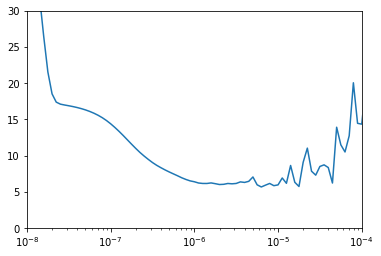

In [0]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-8,1e-4,0,30])

As we observe that the loss is minimum  when the learning rate is 0.00005. So lets train the model once again with this values and then see the error.

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size , batch_size = 128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 1s 145ms/step - loss: 80.8704 - mae: 83.5782
Epoch 2/400
8/8 [==============================] - 0s 22ms/step - loss: 23.3276 - mae: 24.1570
Epoch 3/400
8/8 [==============================] - 0s 21ms/step - loss: 17.8614 - mae: 18.4302
Epoch 4/400
8/8 [==============================] - 0s 22ms/step - loss: 11.9517 - mae: 12.5089
Epoch 5/400
8/8 [==============================] - 0s 18ms/step - loss: 9.9229 - mae: 10.1368
Epoch 6/400
8/8 [==============================] - 0s 19ms/step - loss: 13.7531 - mae: 14.3888
Epoch 7/400
8/8 [==============================] - 0s 18ms/step - loss: 9.6444 - mae: 10.0865
Epoch 8/400
8/8 [==============================] - 0s 18ms/step - loss: 11.9429 - mae: 12.3598
Epoch 9/400
8/8 [==============================] - 0s 20ms/step - loss: 13.2042 - mae: 13.7624
Epoch 10/400
8/8 [==============================] - 0s 18ms/step - loss: 9.5772 - mae: 10.0502
Epoch 11/400
8/8 [==============================] -

461
461


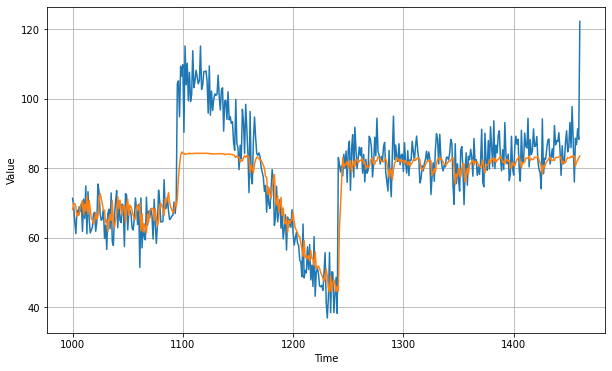

In [0]:
#code for the generalised output ;

forecast = []

# we make prediction for the entire series :
# but while checking performance take into consideration only the x_text part 
for i in range(len(series) - window_size):
  forecast.append(model.predict(series[i:i+window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:,0,0]

print(len(forecast))
print(len(results))

plt.figure(figsize=(10, 6))

plot_series(test_time, x_test)
plot_series(test_time, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_test, results).numpy()

6.4141674

<Figure size 432x288 with 0 Axes>

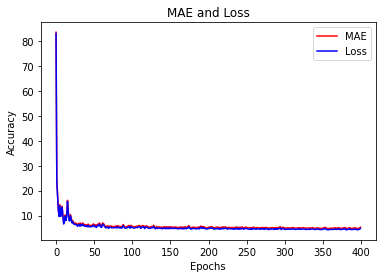

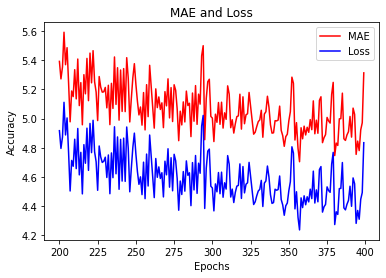

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

###LSTM based Model 

Lets define the functions for the series data creation :

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

Use the Functions defined to create the actual series data 

In [0]:

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series

series = baseline +\
         trend(time, slope) +\
         seasonality(time, period=365, amplitude=amplitude)+\
         noise(time, noise_level, seed=42)

Train Test Split of Dataset :

In [0]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

Define the function for creation of tain test data from the series data :

In [0]:
''' 
Xs = [1,2,3,4,5,6,7,,8,9,10]

window_size = 4
batch_size = 3

Ys  =  [ [ 
           [1,2,3,4][5] ,
           [2,3,4,5][6] ,
           [3,4,5,6][7]   
         ],
         [ [4,5,6,7][8] , 
           [5,6,7,8][9] , 
           [6,7,8,9][10]  
         ]    
       ]
'''

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

Clear the session for fresh Model :

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

Define the parameters for the windowed dataset creation :

In [0]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

Define the **LSTM Model**

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

Define the **LearningRateScheduler** :

In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

Compile the Model :

In [0]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9),
              metrics=["mae"])

Now lets train the LSTM based Model :

In [0]:
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 4s 113ms/step - loss: 21.4949 - mae: 22.0115
Epoch 2/100
31/31 [==============================] - 1s 21ms/step - loss: 21.1328 - mae: 21.6472
Epoch 3/100
31/31 [==============================] - 1s 20ms/step - loss: 20.7158 - mae: 21.2292
Epoch 4/100
31/31 [==============================] - 1s 20ms/step - loss: 20.2701 - mae: 20.7798
Epoch 5/100
31/31 [==============================] - 1s 20ms/step - loss: 19.7780 - mae: 20.2896
Epoch 6/100
31/31 [==============================] - 1s 21ms/step - loss: 19.1758 - mae: 19.6838
Epoch 7/100
31/31 [==============================] - 1s 21ms/step - loss: 18.2329 - mae: 18.7455
Epoch 8/100
31/31 [==============================] - 1s 21ms/step - loss: 17.4745 - mae: 17.9816
Epoch 9/100
31/31 [==============================] - 1s 23ms/step - loss: 17.1541 - mae: 17.6597
Epoch 10/100
31/31 [==============================] - 1s 21ms/step - loss: 16.8486 - mae: 17.3525
Epoch 11/100
31/31 [========

Lets now plot the graph of LearningRate Vs Loss to find the optimal Learning Rate :

(1e-08, 0.0001, 0.0, 30.0)

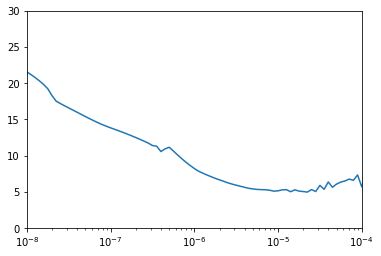

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

Now lets train the Model with the Optimal Learning Rate :

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

#create the train data
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

#create the model :
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

#Compile the model ;
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])

#Train the Model :
history = model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
31/31 [==============================] - 2s 79ms/step - loss: 7146.6124 - mae: 47.4993
Epoch 2/500
31/31 [==============================] - 0s 11ms/step - loss: 1336.4686 - mae: 22.0189
Epoch 3/500
31/31 [==============================] - 0s 10ms/step - loss: 952.8405 - mae: 18.7166
Epoch 4/500
31/31 [==============================] - 0s 13ms/step - loss: 693.7533 - mae: 18.5125
Epoch 5/500
31/31 [==============================] - 0s 13ms/step - loss: 836.5277 - mae: 21.5778
Epoch 6/500
31/31 [==============================] - 0s 13ms/step - loss: 689.9879 - mae: 19.6107
Epoch 7/500
31/31 [==============================] - 0s 13ms/step - loss: 714.2171 - mae: 20.9119
Epoch 8/500
31/31 [==============================] - 0s 13ms/step - loss: 532.3250 - mae: 17.7423
Epoch 9/500
31/31 [==============================] - 0s 13ms/step - loss: 871.6428 - mae: 21.1898
Epoch 10/500
31/31 [==============================] - 0s 13ms/step - loss: 743.6479 - mae: 21.1932
Epoch 11/500
31/3

Lets now do the prediction with this optimal Model trained :

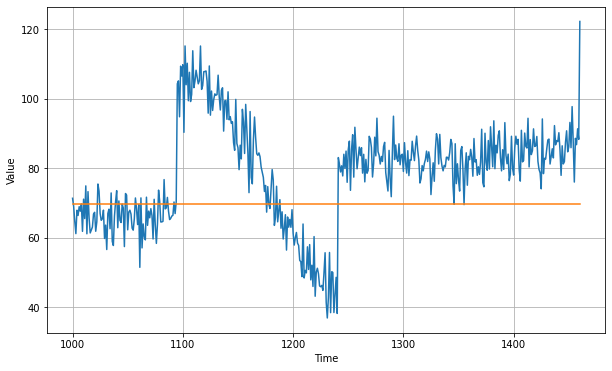

In [0]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

LEts find the error wrt the original values :

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

14.258361

Lets now observ the parameters :


<Figure size 432x288 with 0 Axes>

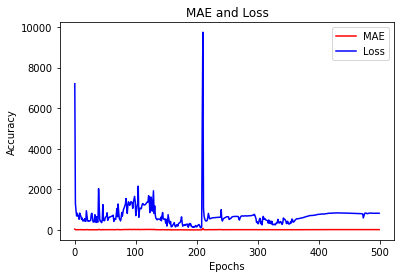

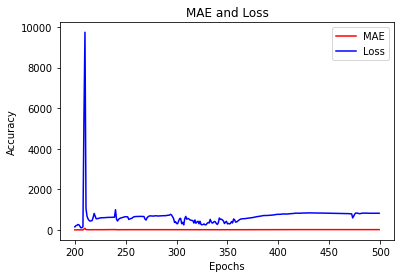

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

### 2 LSTM layers :

In [0]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size , shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))

model.fit(dataset,epochs=100, verbose=1)

Epoch 1/100
31/31 [==============================] - 4s 115ms/step - loss: 1215.1538
Epoch 2/100
31/31 [==============================] - 1s 20ms/step - loss: 147.1766
Epoch 3/100
31/31 [==============================] - 1s 21ms/step - loss: 95.6130
Epoch 4/100
31/31 [==============================] - 1s 20ms/step - loss: 80.0144
Epoch 5/100
31/31 [==============================] - 1s 21ms/step - loss: 75.4509
Epoch 6/100
31/31 [==============================] - 1s 21ms/step - loss: 72.4546
Epoch 7/100
31/31 [==============================] - 1s 21ms/step - loss: 65.2926
Epoch 8/100
31/31 [==============================] - 1s 21ms/step - loss: 60.0033
Epoch 9/100
31/31 [==============================] - 1s 20ms/step - loss: 57.2525
Epoch 10/100
31/31 [==============================] - 1s 20ms/step - loss: 56.5672
Epoch 11/100
31/31 [==============================] - 1s 20ms/step - loss: 56.1517
Epoch 12/100
31/31 [==============================] - 1s 20ms/step - loss: 55.0060
Epoch 13/

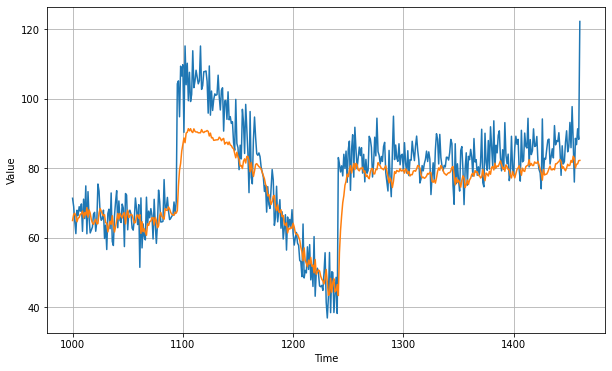

In [0]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.35908

### 3 LSTM Layers & Its Performance 

In [0]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))

model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 5s 166ms/step - loss: 427.5420
Epoch 2/100
31/31 [==============================] - 1s 29ms/step - loss: 118.3621
Epoch 3/100
31/31 [==============================] - 1s 29ms/step - loss: 89.5406
Epoch 4/100
31/31 [==============================] - 1s 30ms/step - loss: 78.6903
Epoch 5/100
31/31 [==============================] - 1s 30ms/step - loss: 73.0461
Epoch 6/100
31/31 [==============================] - 1s 29ms/step - loss: 69.5966
Epoch 7/100
31/31 [==============================] - 1s 29ms/step - loss: 66.8876
Epoch 8/100
31/31 [==============================] - 1s 30ms/step - loss: 64.2462
Epoch 9/100
31/31 [==============================] - 1s 29ms/step - loss: 61.3696
Epoch 10/100
31/31 [==============================] - 1s 30ms/step - loss: 58.6397
Epoch 11/100
31/31 [==============================] - 1s 29ms/step - loss: 56.6098
Epoch 12/100
31/31 [==============================] - 1s 30ms/step - loss: 55.3109
Epoch 13/1

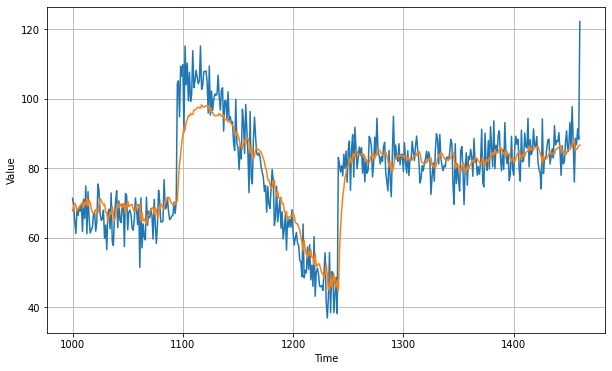

In [0]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.305975

###Exercise 3 - Mean Absolute Error



In class you learned about RNNs and LSTMs for prediction, as well as a simple methodology to pick a decent learning rate for the stochastic gradient descent optimizer. In this exercise you’ll take a synthetic data set and write the code to pick the learning rate and then train on it to get an MAE of < 3

In [0]:
!pip install tensorflow==2.0.0-beta0

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

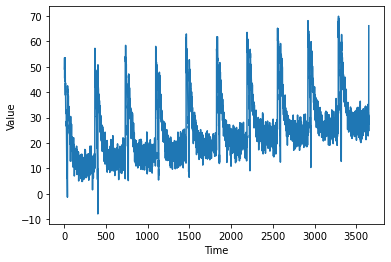

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype = "float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x : tf.expand_dims(x,axis = -1) , input_shape = [None] ),# YOUR CODE HERE),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  # YOUR CODE HERE
  tf.keras.layers.Lambda(lambda x : x *100.0)# YOUR CODE HERE)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 6s 66ms/step - loss: 8.6345 - mae: 9.0221
Epoch 2/100
94/94 [==============================] - 3s 28ms/step - loss: 8.1609 - mae: 8.5435
Epoch 3/100
94/94 [==============================] - 3s 28ms/step - loss: 7.8279 - mae: 8.2059
Epoch 4/100
94/94 [==============================] - 3s 28ms/step - loss: 7.6056 - mae: 7.9815
Epoch 5/100
94/94 [==============================] - 3s 28ms/step - loss: 7.4530 - mae: 7.8250
Epoch 6/100
94/94 [==============================] - 3s 28ms/step - loss: 7.3393 - mae: 7.7092
Epoch 7/100
94/94 [==============================] - 3s 28ms/step - loss: 7.2448 - mae: 7.6123
Epoch 8/100
94/94 [==============================] - 3s 29ms/step - loss: 7.1571 - mae: 7.5238
Epoch 9/100
94/94 [==============================] - 3s 29ms/step - loss: 7.0705 - mae: 7.4365
Epoch 10/100
94/94 [==============================] - 3s 29ms/step - loss: 6.9826 - mae: 7.3484
Epoch 11/100
94/94 [=============================

(1e-08, 0.0001, 0.0, 30.0)

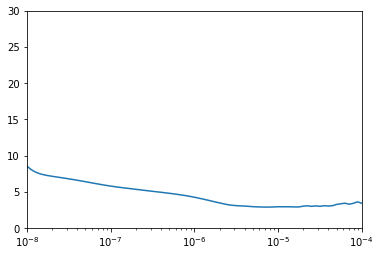

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

# FROM THIS PICK A LEARNING RATE

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x : tf.expand_dims(x,axis = -1) , input_shape = [None] ),# YOUR CODE HERE),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  # YOUR CODE HERE
  tf.keras.layers.Lambda(lambda x : x *100.0)# YOUR CODE HERE)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr= 1.0e-5, momentum=0.9),metrics=["mae"])# PUT YOUR LEARNING RATE HERE#, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=200,verbose=1)
                                                            
# FIND A MODEL AND A LR THAT TRAINS TO AN MAE < 3                                                          

Epoch 1/200
94/94 [==============================] - 6s 66ms/step - loss: 317.3262 - mae: 10.6099
Epoch 2/200
94/94 [==============================] - 3s 28ms/step - loss: 43.9133 - mae: 4.3734
Epoch 3/200
94/94 [==============================] - 3s 28ms/step - loss: 38.1663 - mae: 4.0789
Epoch 4/200
94/94 [==============================] - 3s 29ms/step - loss: 35.4673 - mae: 3.9329
Epoch 5/200
94/94 [==============================] - 3s 29ms/step - loss: 34.3148 - mae: 3.8666
Epoch 6/200
94/94 [==============================] - 3s 29ms/step - loss: 35.0763 - mae: 3.9453
Epoch 7/200
94/94 [==============================] - 3s 29ms/step - loss: 32.9886 - mae: 3.7930
Epoch 8/200
94/94 [==============================] - 3s 29ms/step - loss: 33.0332 - mae: 3.8177
Epoch 9/200
94/94 [==============================] - 3s 28ms/step - loss: 31.9545 - mae: 3.7345
Epoch 10/200
94/94 [==============================] - 3s 29ms/step - loss: 31.5508 - mae: 3.7091
Epoch 11/200
94/94 [=================

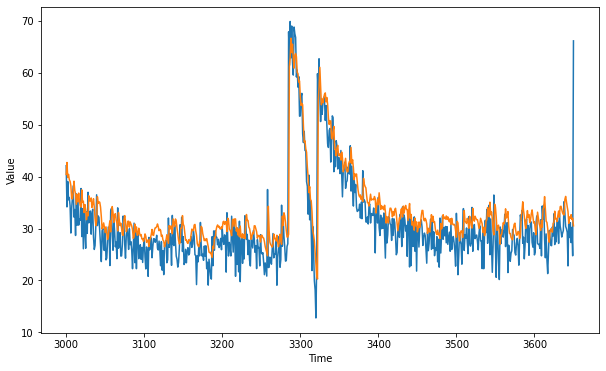

In [0]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# YOUR RESULT HERE SHOULD BE LESS THAN 4

3.8616123

<Figure size 432x288 with 0 Axes>

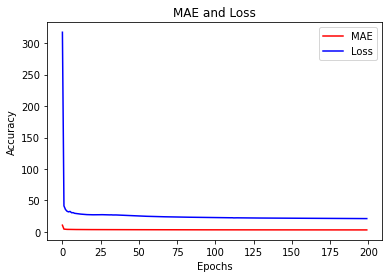

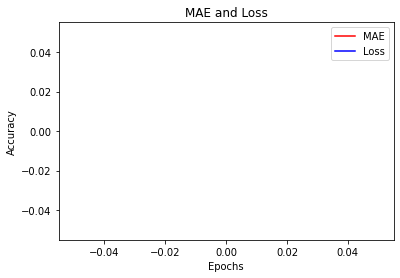

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()